In [83]:
!pip install pyqt5  # for more advanced GUIs, if desired
!pip install streamlit


In [84]:
!pip install seaborn


In [85]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import sklearn
import sys

# Check versions (optional but useful for reproducibility)
print("Python version:", sys.version)
print("NumPy version:", np.__version__)
print("TensorFlow version:", tf.__version__)

Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
NumPy version: 2.0.2
TensorFlow version: 2.18.0


In [86]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




```# Phase 1: Project Setup
This notebook initializes the environment and libraries for the modulation classification project.
```



In [87]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import sklearn
import sys

print("Python:", sys.version)
print("NumPy:", np.__version__)
print("TensorFlow:", tf.__version__)


Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
NumPy: 2.0.2
TensorFlow: 2.18.0


In [88]:
def psk8_gen(bits, fs=FS):
    # Group bits into triplets
    bits = bits[:(len(bits)//3)*3]
    symbols = bits.reshape(-1, 3)
    # 8 states, phase increments of pi/4 per symbol integer
    mapping = [np.exp(1j*2*np.pi*k/8) for k in range(8)]
    symbols_dec = [b[0]*4 + b[1]*2 + b[2] for b in symbols]
    modulated = np.array([mapping[idx] for idx in symbols_dec])
    return np.repeat(modulated, fs).astype(np.complex64)

In [89]:
def qam64_gen(bits, fs=FS):
    bits = bits[:(len(bits)//6)*6]
    symbols = bits.reshape(-1, 6)
    # Map bits to grid: 8 I-levels, 8 Q-levels with Gray coding for min errors
    # Pattern: see standard 64QAM symbol table for mapping
    def gray_to_level(val):  # 3 bits to level (-7, -5, ..., +7)
        table = [ -7, -5, -1, -3, +7, +5, +1, +3 ]
        return table[val]
    levels = np.array([gray_to_level(int("".join(str(b) for b in s[:3]), 2)) +
                       1j*gray_to_level(int("".join(str(b) for b in s[3:]), 2)) for s in symbols])
    # Rescale for normalized power
    levels = levels / np.sqrt((42))  # 1/average symbol power for 64QAM
    return np.repeat(levels, fs).astype(np.complex64)

In [90]:
def ask4_gen(bits, fs=FS):
    bits = bits[:(len(bits)//2)*2]
    symbols = bits.reshape(-1, 2)
    # 00→-3, 01→-1, 11→+1, 10→+3
    mapping = {(0,0): -3, (0,1): -1, (1,1): +1, (1,0): +3}
    modulated = np.array([mapping[tuple(pair)] for pair in symbols]) / np.sqrt(5)
    return np.repeat(modulated, fs).astype(np.complex64)

In [91]:
def qpsk_gen(bits, fs=FS):
    # Group bits into pairs
    bits = bits[:(len(bits)//2)*2]
    symbols = bits.reshape(-1, 2)
    # Gray coding: 00=0, 01=1, 11=2, 10=3 maps to pi/4, 3pi/4, 5pi/4, 7pi/4
    mapping = {(0,0): 1+1j, (0,1): -1+1j, (1,1): -1-1j, (1,0): 1-1j}
    modulated = np.array([mapping[tuple(pair)] for pair in symbols]) / np.sqrt(2)
    return np.repeat(modulated, fs).astype(np.complex64)


In [108]:
#Phase2
import numpy as np
import matplotlib.pyplot as plt

# --- DEFINE ALL PARAMETERS BEFORE USING THEM ---
N_CLASSES = 20
N_SAMPLES = 400   # Reduce or increase as needed
SYMBOLS_PER_SAMPLE = 128
FS = 250           # Now FS is defined before it's used
SNR_RANGE = (0, 30)
FS = 250  # or your chosen sampling rate
RNG = np.random.default_rng(42)
MOD_SCHEMES = list(mod_generators.keys())




#module signal genration

In [93]:
def bpsk_gen(bits, fs=FS):
    symbols = 2*bits - 1
    return np.repeat(symbols, fs).astype(np.complex64)

def qam16_gen(bits, fs=FS):
    mapping = {
        (0,0,0,0): -3-3j, (0,0,0,1): -3-1j, (0,0,1,0): -3+3j, (0,0,1,1): -3+1j,
        (0,1,0,0): -1-3j, (0,1,0,1): -1-1j, (0,1,1,0): -1+3j, (0,1,1,1): -1+1j,
        (1,0,0,0):  3-3j, (1,0,0,1):  3-1j, (1,0,1,0):  3+3j, (1,0,1,1):  3+1j,
        (1,1,0,0):  1-3j, (1,1,0,1):  1-1j, (1,1,1,0):  1+3j, (1,1,1,1):  1+1j
    }
    bits = bits[:(len(bits)//4)*4]
    symbols = np.array([mapping[tuple(b)] for b in bits.reshape(-1,4)])
    return np.repeat(symbols, fs).astype(np.complex64) / np.sqrt(10)

def fsk_gen(bits, fs=FS, f0=2, f1=5):
    t = np.arange(len(bits)*fs) / fs
    freq = np.repeat(np.where(bits==0, f0, f1), fs)
    return np.exp(1j*2*np.pi*freq*t).astype(np.complex64)

def awgn(sig, snr_db):
    sig_power = np.mean(np.abs(sig)**2)
    snr_linear = 10**(snr_db / 10)
    noise_power = sig_power / snr_linear
    noise = np.sqrt(noise_power/2) * (
        RNG.standard_normal(len(sig)) + 1j*RNG.standard_normal(len(sig)))
    return sig + noise


In [94]:
# ===== ADVANCED CHANNEL SIMULATION FUNCTIONS =====
# Place this section after your modulation generators and before dataset creation

def rayleigh_fading(sig, fs=FS):
    """
    Simulate Rayleigh fading channel
    - Creates random amplitude and phase variations
    - Simulates multipath propagation effects
    """
    # Generate complex Gaussian random variables for fading coefficients
    h_real = RNG.standard_normal(len(sig))
    h_imag = RNG.standard_normal(len(sigreal + 1j * h_imag) / np.sqrt(2))  # Rayleigh distributed magnitude
    return sig * h

def freq_offset(sig, offset_hz=100, fs=FS):
    """
    Add frequency offset to simulate oscillator drift
    - Common in real RF systems due to hardware imperfections
    """
    t = np.arange(len(sig)) / fs
    return sig * np.exp(1j * 2 * np.pi * offset_hz * t)

def phase_jitter(sig, max_phase_deg=10):
    """
    Add random phase noise/jitter
    - Simulates phase noise from oscillators and PLLs
    """
    phase_noise = RNG.uniform(-max_phase_deg, max_phase_deg, len(sig)) * np.pi / 180
    return sig * np.exp(1j * phase_noise)

def timing_offset(sig, max_offset_samples=5):
    """
    Add timing/sampling offset
    - Simulates synchronization errors
    """
    offset = RNG.integers(-max_offset_samples, max_offset_samples + 1)
    if offset > 0:
        return np.concatenate([np.zeros(offset, dtype=np.complex64), sig[:-offset]])
    elif offset < 0:
        return np.concatenate([sig[-offset:], np.zeros(-offset, dtype=np.complex64)])
    return sig

def realistic_channel(sig, snr_db,
                     apply_fading=True,
                     apply_freq_offset=True,
                     apply_phase_jitter=True,
                     apply_timing_offset=False):  # Timing offset can cause issues, so default False
    """
    Apply realistic wireless channel effects in sequence

    Parameters:
    - sig: Input clean signal
    - snr_db: Signal-to-noise ratio in dB
    - apply_*: Boolean flags to enable/disable specific effects

    Returns:
    - Signal with realistic channel impairments
    """
    # Apply channel effects in realistic order
    if apply_fading:
        sig = rayleigh_fading(sig)

    if apply_freq_offset:
        # Random frequency offset between -200 and +200 Hz
        offset = RNG.uniform(-200, 200)
        sig = freq_offset(sig, offset)

    if apply_phase_jitter:
        # Random phase jitter up to ±5 degrees
        sig = phase_jitter(sig, max_phase_deg=5)

    if apply_timing_offset:
        sig = timing_offset(sig, max_offset_samples=3)

    # Add AWGN noise last (most realistic order)
    sig = awgn(sig, snr_db)

    return sig


Data Set Genration

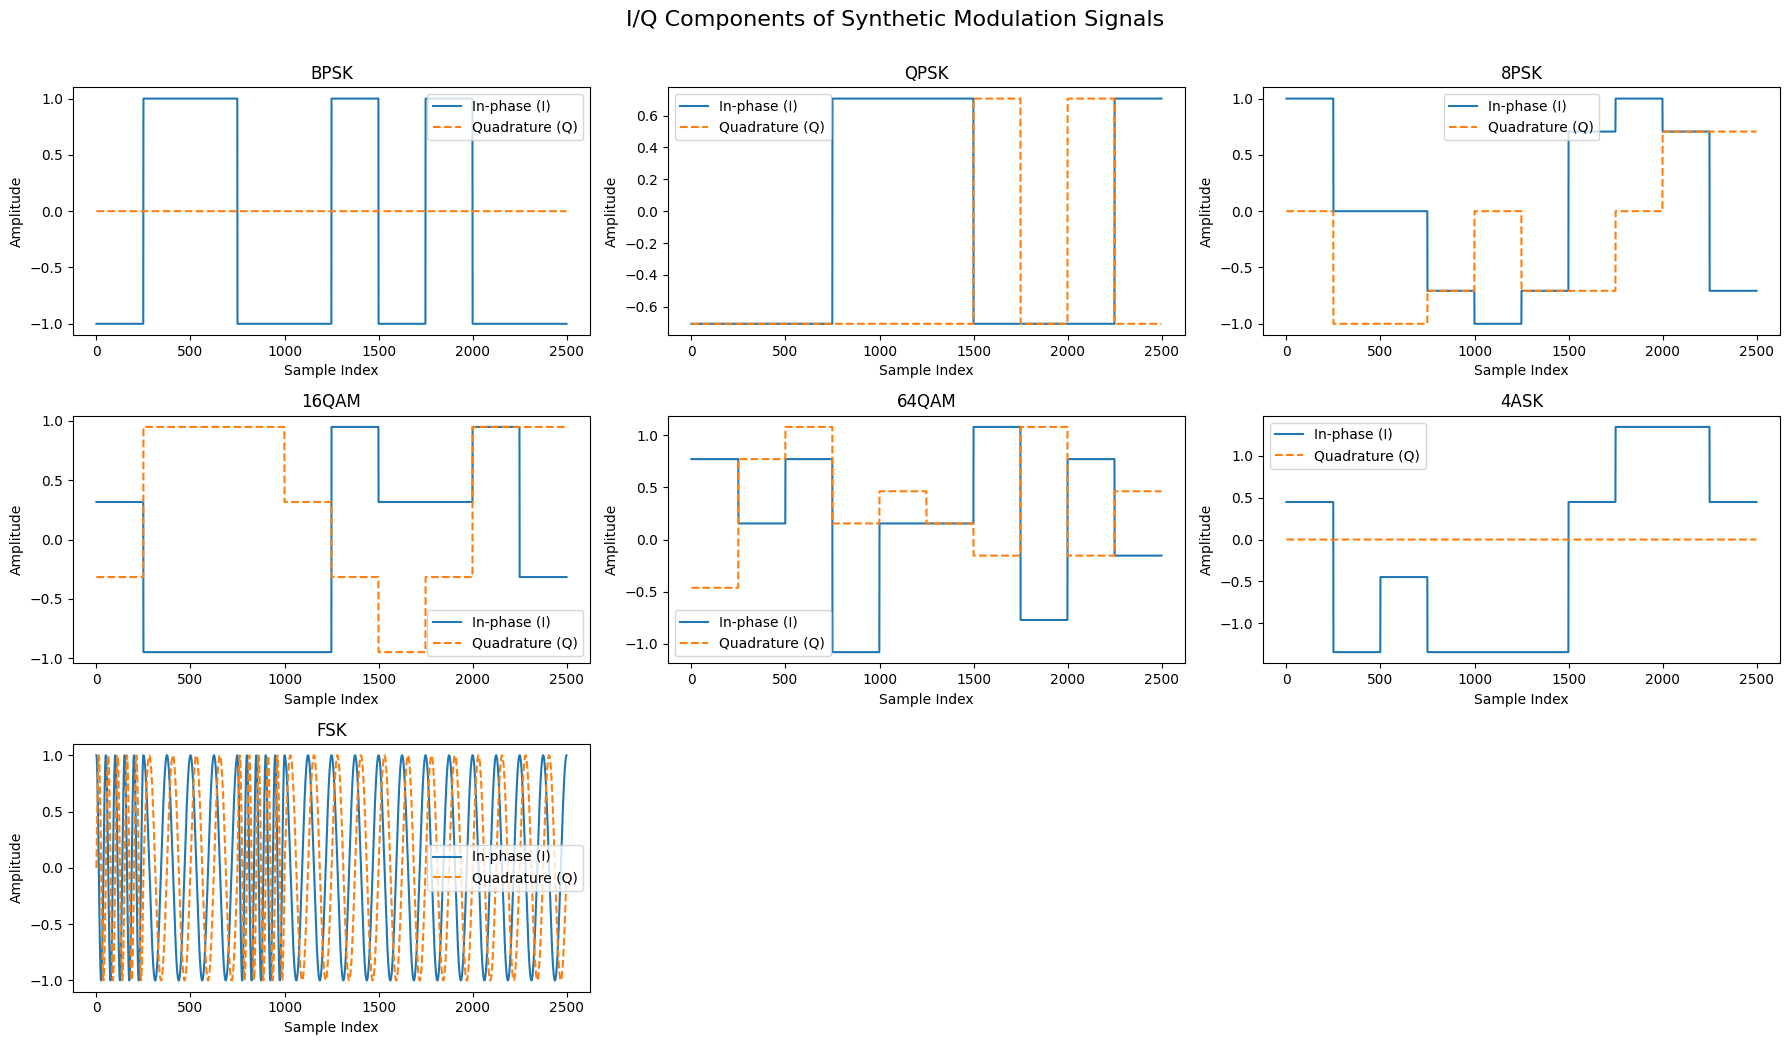

In [115]:
mod_generators = {
    'BPSK': bpsk_gen,
    'QPSK': qpsk_gen,
    '8PSK': psk8_gen,
    '16QAM': qam16_gen,
    '64QAM': qam64_gen,
    '4ASK': ask4_gen,
    'FSK': fsk_gen
}
import matplotlib.pyplot as plt

# Generate one random example per modulation type
def generate_modulated_dataset(mod_generators, mod_schemes, samples_per_class=100, n_symbols=100, fs=1000):
    X = []
    y = []
    rng = np.random.default_rng()

    for mod_name in mod_schemes:
        gen_fn = mod_generators[mod_name]
        for _ in range(samples_per_class):
            # Determine number of bits based on modulation
            if mod_name in ['BPSK', 'FSK']:
                bits = rng.integers(0, 2, n_symbols)
            elif mod_name == 'QPSK':
                bits = rng.integers(0, 2, n_symbols * 2)
            elif mod_name == '8PSK':
                bits = rng.integers(0, 2, n_symbols * 3)
            elif mod_name == '16QAM':
                bits = rng.integers(0, 2, n_symbols * 4)
            elif mod_name == '64QAM':
                bits = rng.integers(0, 2, n_symbols * 6)
            elif mod_name == '4ASK':
                bits = rng.integers(0, 2, n_symbols * 2)
            else:
                raise ValueError(f"Unknown modulation: {mod_name}")

            signal = gen_fn(bits)
            X.append(signal)
            y.append(mod_name)

    return np.array(X), np.array(y)


# Matplotlib visualization
plt.figure(figsize=(18, 10))
for idx, (sig, mod) in enumerate(zip(example_signals, titles)):
    plt.subplot(3, 3, idx+1)
    plt.plot(np.real(sig[:FS_PLOT * N_SYMBOLS_PLOT]), label='In-phase (I)')
    plt.plot(np.imag(sig[:FS_PLOT * N_SYMBOLS_PLOT]), label='Quadrature (Q)', linestyle='--')
    plt.title(mod)
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend()
plt.tight_layout()
plt.suptitle('I/Q Components of Synthetic Modulation Signals', fontsize=16, y=1.04)
plt.show()




In [96]:

X = np.array(example_signals)
y = np.array([MOD_SCHEMES.index(title) for title in titles])



Plot Example Signals (Visualization)

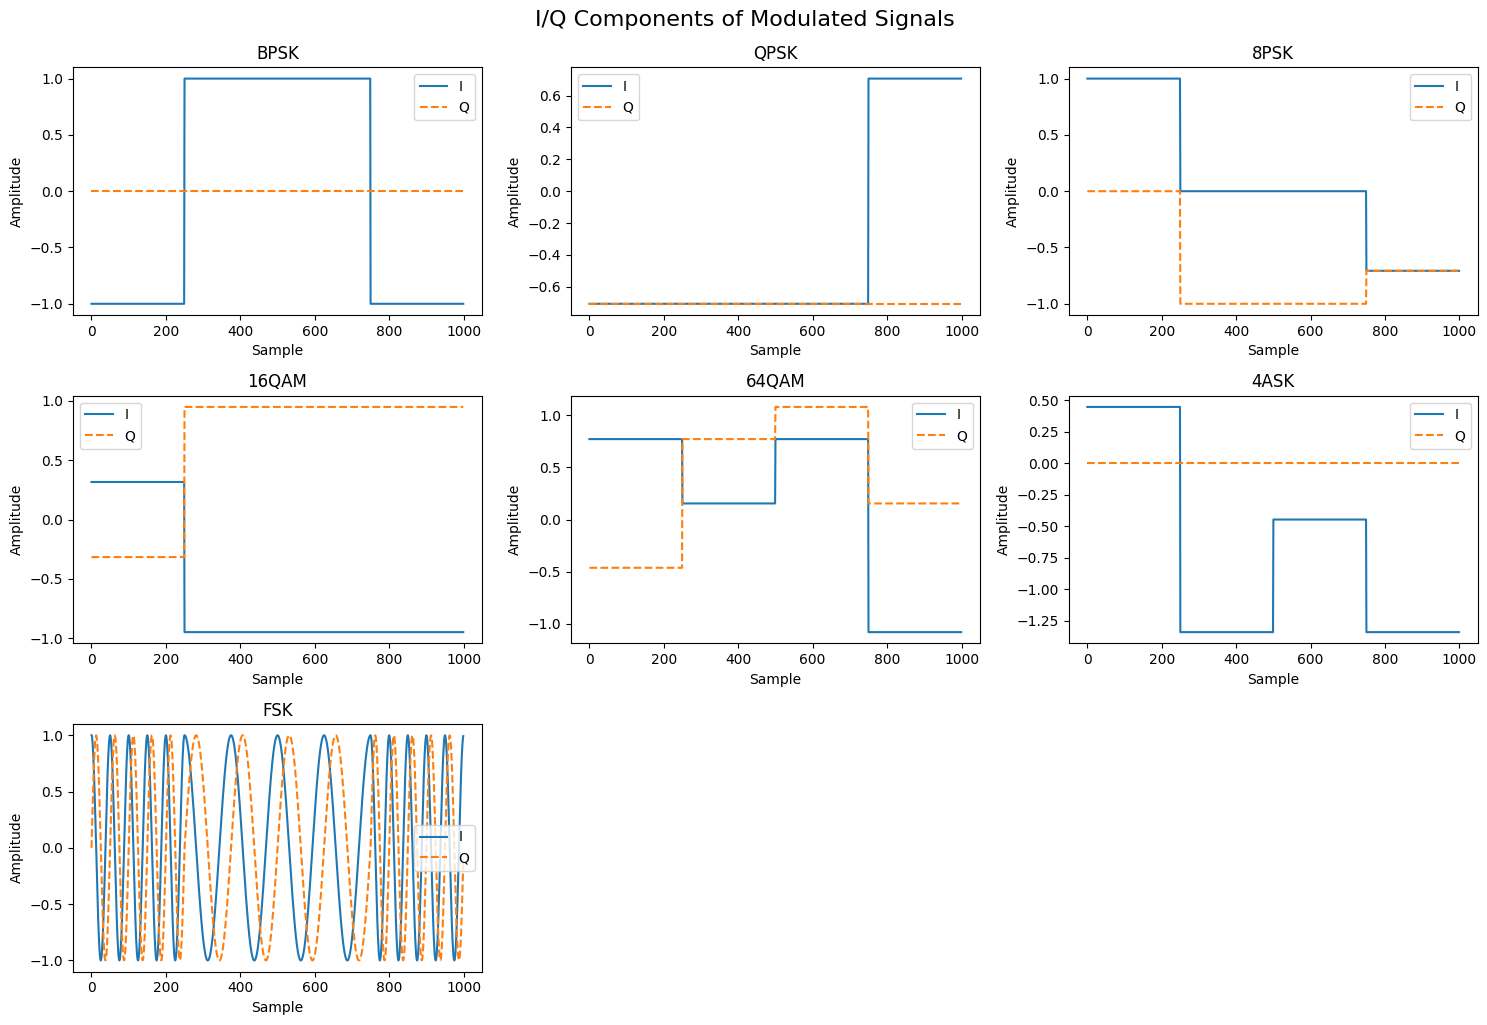

In [97]:
plt.figure(figsize=(15, 10))
for i, scheme in enumerate(MOD_SCHEMES):
    plt.subplot(3, 3, i+1)
    plt.title(scheme)
    plt.plot(np.real(X[i][:FS*4]), label='I')
    plt.plot(np.imag(X[i][:FS*4]), label='Q', linestyle='--')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend()

plt.tight_layout()
plt.suptitle("I/Q Components of Modulated Signals", fontsize=16, y=1.02)
plt.show()


In [109]:
# For CNN: [samples, timesteps, channels]
X_cnn = np.stack([np.stack([np.real(x), np.imag(x)], axis=1) for x in X])
print("CNN input shape:", X_cnn.shape)


CNN input shape: (7, 2500, 2)


In [110]:
np.save('/content/X_cnn.npy', X_cnn)
np.save('/content/y.npy', y)


In [116]:
MOD_SCHEMES = ['BPSK', 'QPSK', '8PSK', '16QAM', '64QAM', '4ASK', 'FSK']
FS = 1000  # Sampling frequency used in your modulation functions

X, y = generate_modulated_dataset(
    mod_generators=mod_generators,
    mod_schemes=MOD_SCHEMES,
    samples_per_class=100,
    n_symbols=100,  # Number of symbols per sample
    fs=FS
)

print("✅ Dataset generated:", X.shape, y.shape)



✅ Dataset generated: (700, 25000) (700,)


In [117]:
from collections import Counter
print("Original class distribution:", Counter(y))
print("Total samples:", len(y))

Original class distribution: Counter({np.str_('BPSK'): 100, np.str_('QPSK'): 100, np.str_('8PSK'): 100, np.str_('16QAM'): 100, np.str_('64QAM'): 100, np.str_('4ASK'): 100, np.str_('FSK'): 100})
Total samples: 700


In [119]:
def convert_complex_to_features(X_complex):
    X_features = []
    for sig in X_complex:
        # Extract simple statistical features (example)
        features = [
            np.mean(np.real(sig)),
            np.std(np.real(sig)),
            np.mean(np.imag(sig)),
            np.std(np.imag(sig)),
            np.mean(np.abs(sig)),
            np.std(np.abs(sig))
        ]
        X_features.append(features)
    return np.array(X_features)

X_ml = convert_complex_to_features(X)


In [120]:
# Filter classes with at least 2 samples
class_counts = Counter(y)
valid_classes = [cls for cls, count in class_counts.items() if count >= 2]

X_ml_filtered = X_ml[np.isin(y, valid_classes)]
y_filtered = y[np.isin(y, valid_classes)]


Split the dataset

In [121]:
from collections import Counter

# Show class counts
print("Original class distribution:")
print(Counter(y))

# OPTIONAL: If you want to check after filtering
print("\nFiltered class distribution (>=2 samples):")
label_counts = Counter(y)
valid_classes = [label for label, count in label_counts.items() if count >= 2]
print({label: count for label, count in label_counts.items() if count >= 2})


Original class distribution:
Counter({np.str_('BPSK'): 100, np.str_('QPSK'): 100, np.str_('8PSK'): 100, np.str_('16QAM'): 100, np.str_('64QAM'): 100, np.str_('4ASK'): 100, np.str_('FSK'): 100})

Filtered class distribution (>=2 samples):
{np.str_('BPSK'): 100, np.str_('QPSK'): 100, np.str_('8PSK'): 100, np.str_('16QAM'): 100, np.str_('64QAM'): 100, np.str_('4ASK'): 100, np.str_('FSK'): 100}


In [126]:
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split

# Count samples per class
label_counts = Counter(y)

# Find valid classes (at least 2 samples)
valid_classes = [label for label, count in label_counts.items() if count >= 2]

# Filter X and y to keep only valid classes
indices_to_keep = [i for i, label in enumerate(y) if label in valid_classes]
X_ml_filtered = X_ml[indices_to_keep]
y_filtered = np.array(y)[indices_to_keep]

# ✅ Sanity check
print("Total samples after filtering:", len(y_filtered))
print("Class distribution after filtering:", Counter(y_filtered))

if len(y_filtered) == 0:
    raise ValueError("❌ No valid samples remaining after filtering. Please check your dataset generation or filtering logic.")

# Now split
X_train, X_test, y_train, y_test = train_test_split(
    X_ml_filtered, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered
)



Total samples after filtering: 700
Class distribution after filtering: Counter({np.str_('BPSK'): 100, np.str_('QPSK'): 100, np.str_('8PSK'): 100, np.str_('16QAM'): 100, np.str_('64QAM'): 100, np.str_('4ASK'): 100, np.str_('FSK'): 100})


For best results with SVM, RandomForest, etc., extract features from each signal

In [130]:
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
import numpy as np

# Feature extraction
def extract_features(sig):
    I = np.real(sig)
    Q = np.imag(sig)
    return [
        I.mean(), I.std(), skew(I), kurtosis(I),
        Q.mean(), Q.std(), skew(Q), kurtosis(Q)
    ]

# Apply feature extraction to all signals
X_feats = np.array([extract_features(sig) for sig in X])

# Split dataset using extracted features and correct labels
X_train, X_test, y_train, y_test = train_test_split(
    X_feats, y, test_size=0.2, random_state=42
)




hoose several classifiers for empirical comparison:

Support Vector Machine (SVM)

Random Forest (RF)

Logistic Regression (LR)

K-Nearest Neighbors (KNN)

Gradient Boosting or XGBoost (if desired)

In [129]:
print(f"Total training samples: {len(X_train)}, Test samples: {len(X_test)}")
print("Train class distribution:", dict(Counter(y_train)))
print("Test class distribution:", dict(Counter(y_test)))


Total training samples: 560, Test samples: 140
Train class distribution: {np.str_('QPSK'): 80, np.str_('BPSK'): 80, np.str_('4ASK'): 80, np.str_('64QAM'): 80, np.str_('FSK'): 80, np.str_('8PSK'): 80, np.str_('16QAM'): 80}
Test class distribution: {np.str_('16QAM'): 20, np.str_('QPSK'): 20, np.str_('4ASK'): 20, np.str_('8PSK'): 20, np.str_('64QAM'): 20, np.str_('FSK'): 20, np.str_('BPSK'): 20}


In [132]:
import numpy as np

print("Any NaNs in feature matrix?", np.isnan(X_feats).any())
print("NaN count per feature column:", np.isnan(X_feats).sum(axis=0))


Any NaNs in feature matrix? True
NaN count per feature column: [  0   0   0   0   0   0 200 200]


In [134]:
import numpy as np
from sklearn.model_selection import train_test_split

# Remove NaN samples
mask = ~np.isnan(X_feats).any(axis=1)
X_clean = X_feats[mask]
y_clean = np.array(y_filtered)[mask]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean
)



In [135]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

models = {
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

results = {}
print("Model Evaluation Results:\n")
for name, clf in models.items():
    try:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, zero_division=0)

        results[name] = {
            "Accuracy": acc,
            "Classification Report": report
        }

        print(f"=== {name} ===")
        print(f"Accuracy: {acc*100:.2f}%")
        print(report)
        print("-" * 40)

    except Exception as e:
        print(f"⚠️ {name} failed: {e}")
        print("-" * 40)

# Accuracy comparison summary
acc_summary = {name: round(metrics["Accuracy"] * 100, 2) for name, metrics in results.items()}
df = pd.DataFrame.from_dict(acc_summary, orient="index", columns=["Test Accuracy (%)"])
print("\nAccuracy Comparison:")
print(df.sort_values("Test Accuracy (%)", ascending=False))


Model Evaluation Results:

=== SVM ===
Accuracy: 69.00%
              precision    recall  f1-score   support

       16QAM       0.67      0.60      0.63        20
       64QAM       0.79      0.75      0.77        20
        8PSK       0.67      0.10      0.17        20
         FSK       0.50      1.00      0.67        20
        QPSK       1.00      1.00      1.00        20

    accuracy                           0.69       100
   macro avg       0.72      0.69      0.65       100
weighted avg       0.72      0.69      0.65       100

----------------------------------------
=== Random Forest ===
Accuracy: 93.00%
              precision    recall  f1-score   support

       16QAM       0.88      0.75      0.81        20
       64QAM       0.83      1.00      0.91        20
        8PSK       0.95      0.90      0.92        20
         FSK       1.00      1.00      1.00        20
        QPSK       1.00      1.00      1.00        20

    accuracy                           0.93      

In [136]:
from collections import Counter
import warnings
warnings.filterwarnings("ignore")  # suppress sklearn warnings for small dataset

results = {}
print("Model Evaluation Results:\n")
for name, clf in models.items():
    try:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, zero_division=0)

        results[name] = {
            "Accuracy": acc,
            "Classification Report": report
        }

        print(f"=== {name} ===")
        print(f"Accuracy: {acc*100:.2f}%")
        print(report)
        print("-" * 40)
    except Exception as e:
        print(f"⚠️ {name} failed: {e}")



Model Evaluation Results:

=== SVM ===
Accuracy: 69.00%
              precision    recall  f1-score   support

       16QAM       0.67      0.60      0.63        20
       64QAM       0.79      0.75      0.77        20
        8PSK       0.67      0.10      0.17        20
         FSK       0.50      1.00      0.67        20
        QPSK       1.00      1.00      1.00        20

    accuracy                           0.69       100
   macro avg       0.72      0.69      0.65       100
weighted avg       0.72      0.69      0.65       100

----------------------------------------
=== Random Forest ===
Accuracy: 95.00%
              precision    recall  f1-score   support

       16QAM       1.00      0.75      0.86        20
       64QAM       0.83      1.00      0.91        20
        8PSK       0.95      1.00      0.98        20
         FSK       1.00      1.00      1.00        20
        QPSK       1.00      1.00      1.00        20

    accuracy                           0.95      

Compare Model Performance

In [137]:
import pandas as pd
summary = {name: res["Accuracy"]*100 for name, res in results.items()}
df = pd.DataFrame.from_dict(summary, orient="index", columns=["Test Accuracy (%)"])
print(df.sort_values("Test Accuracy (%)", ascending=False))


                     Test Accuracy (%)
Random Forest                     95.0
KNN                               84.0
Logistic Regression               71.0
SVM                               69.0


In [138]:
import joblib
joblib.dump(clf, "best_modulation_model.joblib")


['best_modulation_model.joblib']

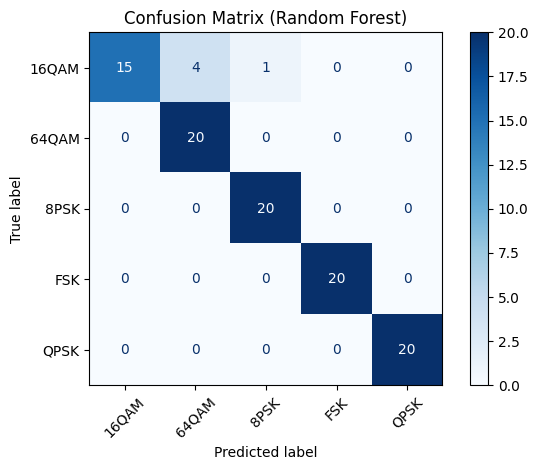

In [140]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Identify best model
best_model_name = df["Test Accuracy (%)"].idxmax()
best_model = models[best_model_name]

# Predict using best model
y_pred = best_model.predict(X_test)

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=sorted(np.unique(y_test)),  # safer than using MOD_SCHEMES directly
    cmap='Blues'
)
plt.title(f"Confusion Matrix ({best_model_name})")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


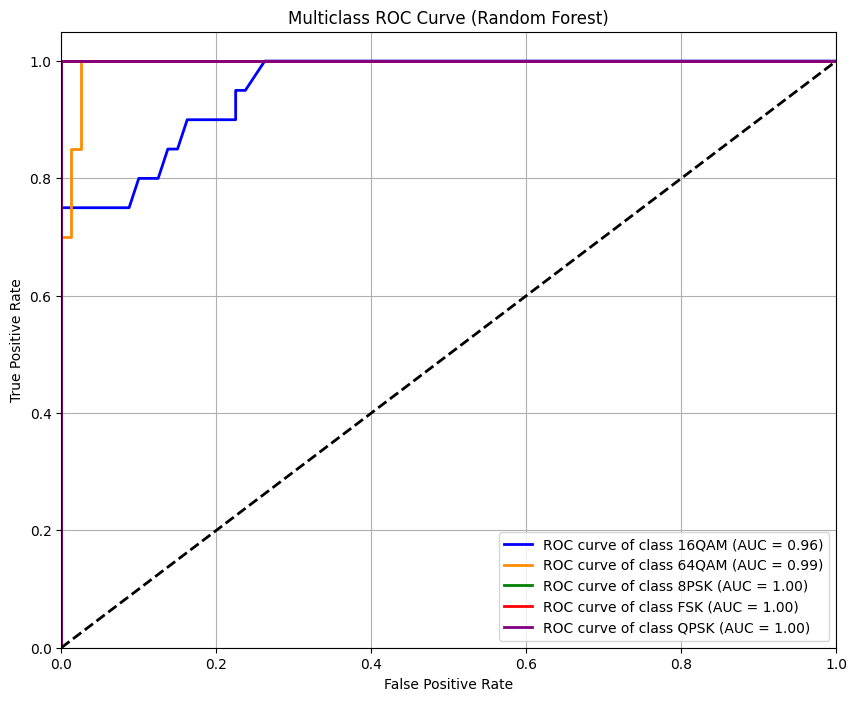

In [142]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np

# Step 1: Binarize the labels
class_labels = sorted(np.unique(y_test))  # safer than using MOD_SCHEMES
y_test_bin = label_binarize(y_test, classes=class_labels)
n_classes = y_test_bin.shape[1]

# Step 2: Get prediction probabilities
# Check if best model supports predict_proba
if hasattr(best_model, "predict_proba"):
    y_score = best_model.predict_proba(X_test)
else:
    # fallback for models like SVM with decision_function
    y_score = best_model.decision_function(X_test)

# Step 3: Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 4: Plot
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'darkorange', 'green', 'red', 'purple', 'brown', 'pink'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {class_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f"Multiclass ROC Curve ({best_model_name})")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [141]:
from sklearn.ensemble import RandomForestClassifier

# Let's assume X_train, y_train are your features/labels from previous cells:
final_rf = RandomForestClassifier()
final_rf.fit(X_train, y_train)



RandomForestClassifier()

In [143]:
from sklearn.ensemble import RandomForestClassifier
import joblib

# 1. Train the model (replace with your actual feature extraction and data split!)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# 2. Save
joblib.dump(rf, 'rf_modulation_classifier.joblib')

# 3. (Optional) Load
model = joblib.load('rf_modulation_classifier.joblib')


In [144]:
best_model = models["Random Forest"]  # or whatever you called it
joblib.dump(best_model, 'rf_modulation_classifier.joblib')


['rf_modulation_classifier.joblib']

In [146]:
# Generate random bits
bits = RNG.integers(0, 2, SYMBOLS_PER_SAMPLE)

# Generate signal using BPSK (or any other modulation you want to test)
new_sig = bpsk_gen(bits)

# Add noise
snr = RNG.uniform(*SNR_RANGE)
new_noisy_sig = awgn(new_sig, snr)

# Extract features
new_feats = np.array(extract_features(new_noisy_sig)).reshape(1, -1)

# Predict using the best-performing model
pred_class = best_model.predict(new_feats)[0]

# Print result
print("Predicted class:", pred_class)


Predicted class: QPSK


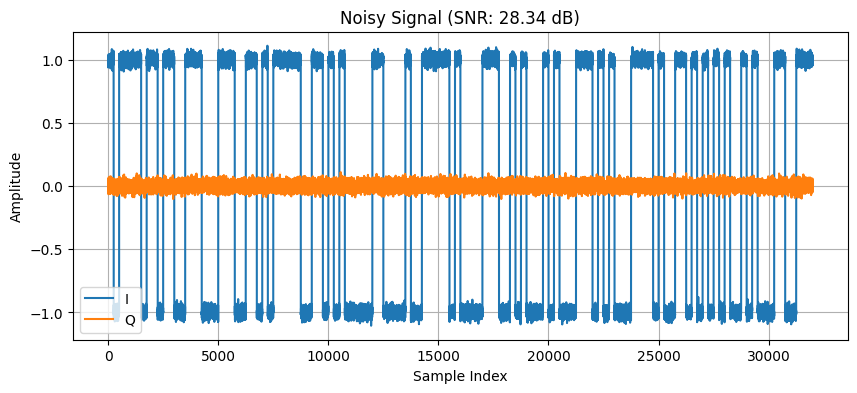

In [149]:
plt.figure(figsize=(10, 4))
plt.plot(np.real(new_noisy_sig), label='I')
plt.plot(np.imag(new_noisy_sig), label='Q')
plt.title(f"Noisy Signal (SNR: {snr:.2f} dB)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


In [150]:
if hasattr(best_model, "predict_proba"):
    probs = best_model.predict_proba(new_feats)[0]
    for label, prob in zip(MOD_SCHEMES, probs):
        print(f"{label}: {prob:.2%}")


BPSK: 25.00%
QPSK: 16.00%
8PSK: 23.00%
16QAM: 1.00%
64QAM: 35.00%


In [147]:
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(random_state=0)
scores = cross_val_score(rf, X_feats, y, cv=5, scoring='accuracy')
print("5-fold Cross-validation accuracies:", scores)
print("Mean accuracy: {:.2f}% (+/- {:.2f}%)".format(np.mean(scores)*100, np.std(scores)*100))


5-fold Cross-validation accuracies: [0.90714286 0.92857143 0.93571429 0.96428571 0.90714286]
Mean accuracy: 92.86% (+/- 2.12%)


In [148]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 8, 16, None],
    'min_samples_split': [2, 5, 10]
}
gs_rf = GridSearchCV(RandomForestClassifier(random_state=0), param_grid, cv=5, n_jobs=-1)
gs_rf.fit(X_train, y_train)
print("Best parameters:", gs_rf.best_params_)
print("Best cross-validated score: {:.2f}%".format(gs_rf.best_score_*100))
best_rf = gs_rf.best_estimator_


Best parameters: {'max_depth': 16, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validated score: 92.00%


In [151]:
importances = best_rf.feature_importances_
feature_names = ['I_mean','I_std','I_skew','I_kurt','Q_mean','Q_std','Q_skew','Q_kurt']
for name, val in zip(feature_names, importances):
    print(f"{name}: {val:.3f}")


I_mean: 0.051
I_std: 0.114
I_skew: 0.060
I_kurt: 0.278
Q_mean: 0.053
Q_std: 0.110
Q_skew: 0.053
Q_kurt: 0.281


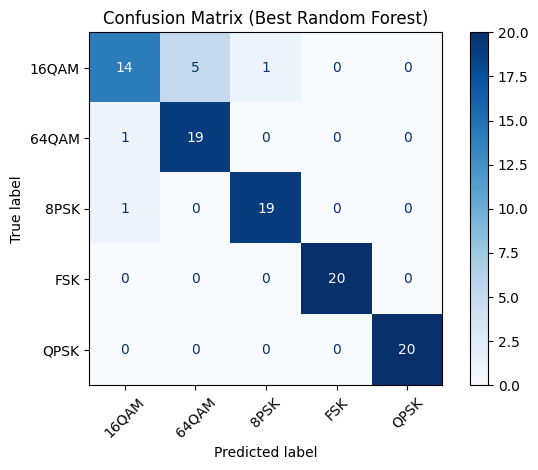

In [155]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Predict
y_pred = best_rf.predict(X_test)

# Use unique string labels directly
unique_labels = np.unique(np.concatenate((y_test, y_pred)))

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=unique_labels,
    cmap='Blues',
    xticks_rotation=45
)
plt.title("Confusion Matrix (Best Random Forest)")
plt.tight_layout()
plt.show()


In [ ]:
!pip  install streamlit


In [157]:
import joblib
joblib.dump(best_rf, "best_rf_model.pkl")


['best_rf_model.pkl']

In [158]:
from google.colab import files
files.download("best_rf_model.pkl")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [159]:
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import joblib

# Load model
model = joblib.load("best_rf_model.pkl")  # Ensure this file is saved from Colab
mod_classes = ['BPSK', 'QPSK', '8PSK', '16QAM', '64QAM', '4ASK', 'FSK']  # Update based on your model

# Feature extractor
def extract_features(sig):
    I = np.real(sig)
    Q = np.imag(sig)
    return [
        I.mean(), I.std(), skew(I), kurtosis(I),
        Q.mean(), Q.std(), skew(Q), kurtosis(Q)
    ]

# Streamlit UI
st.title("📡 Modulation Classifier")
st.write("Upload a `.npy` file containing a complex baseband signal:")

uploaded_file = st.file_uploader("Choose a .npy signal file", type=["npy"])

if uploaded_file is not None:
    try:
        sig = np.load(uploaded_file)
        if not np.iscomplexobj(sig):
            st.error("Uploaded signal must be complex-valued!")
        else:
            st.success("Signal loaded successfully.")
            st.write("Signal length:", len(sig))

            # Show signal plot
            fig, ax = plt.subplots()
            ax.plot(np.real(sig), label="In-phase (I)")
            ax.plot(np.imag(sig), label="Quadrature (Q)")
            ax.legend()
            ax.set_title("Signal Plot")
            st.pyplot(fig)

            # Extract features & predict
            feats = np.array(extract_features(sig)).reshape(1, -1)
            pred = model.predict(feats)[0]
            st.subheader(f"🔍 Predicted Modulation: **{pred}**")
    except Exception as e:
        st.error(f"Error: {e}")


2025-07-28 22:28:39.693 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-28 22:28:39.905 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-07-28 22:28:39.912 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-28 22:28:39.916 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-28 22:28:39.924 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-28 22:28:39.927 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-28 22:28:39.930 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-28 22:28:39.933 Thread 'MainThread': mi

In [160]:
import numpy as np

# Generate a dummy complex signal (like BPSK)
def generate_test_signal():
    bits = np.random.randint(0, 2, 1000)
    signal = 2 * bits - 1  # BPSK modulation: 0 → -1, 1 → +1
    return signal.astype(np.complex64)  # Ensure it's complex

test_signal = generate_test_signal()

# Save it
np.save("test_signal.npy", test_signal)

# Download
from google.colab import files
files.download("test_signal.npy")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>